In [1]:
import numpy as np
import pandas as pd


from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

from psql_functions import execQuery
from miss_data import add_missing_dates, add_missing_counts
from make_plots import dict_error_plot_epsilons, dict_error_plot_n

import warnings
warnings.filterwarnings('ignore')

import sys
import os
import re
owd = os.getcwd()

In [2]:
param_dic = {
    "host"      : "localhost",
    "database"  : "bachelorBesoeg2014",
    "user"      : "postgres",
    "password"  : "password",
    "port"      : "5432"
}

query = """select time_ from _775147;"""
result = execQuery(param_dic, query)
dates = [(date[0]) for date in result]

query = """select count_ from _775147;"""
result = execQuery(param_dic, query)

counts = [(count[0]) for count in result]

all_dates = add_missing_dates(dates)
all_counts =  add_missing_counts(counts, dates, all_dates)

n_data_structures = 50


Executed query and closed connection.
Executed query and closed connection.


In [3]:
onlydirs = [f for f in os.listdir(os.getcwd()) if os.path.isdir(os.path.join(os.getcwd(), f)) and f[0] != '.']

In [4]:
onlydirs

['Data', 'plots', 'range_queries', 'results', '__pycache__']

In [5]:
def make_lookup_error_dict_e_n(epsilons, n):
    epsilon_dict = dict.fromkeys(epsilons)
    n_dicts = []
    for i in range(0,len(epsilons)):
        n_dict = dict.fromkeys(n)
        n_dicts.append(n_dict)

    i = 0
    for e_key in epsilon_dict:
        epsilon_dict[e_key] = n_dicts[i]
        i = i + 1
    return epsilon_dict

def make_query_lookup_dict_n_r(n, rs):
    n_dict = dict.fromkeys(n)
    r_dicts = []
    for i in range(0,len(n)):
        #print(rs[i])
        r_dict = dict.fromkeys(rs[i])
        r_dicts.append(r_dict)

    for idx, n_key in enumerate(n_dict):
            n_dict[n_key] = r_dicts[idx]
    
    return n_dict

def fill_up_query_lookup_dict_n_r(n, rs, files):
    dict_ = make_query_lookup_dict_n_r(n, rs)
    for idx, f in enumerate(files):
        here_n = re.search(r'N=\d+', f).group(0)
        here_n = here_n.split("N=")[1]
        here_r = re.search(r'r=\d+', f).group(0) 
        here_r = here_r.split("r=")[1]
        
        querries = load_range_queries_n_split(f, n_data_structures)
        dict_[int(here_n)][int(here_r)] = querries.copy()
    return dict_

In [6]:
def make_lookup_error_dict(epsilons, n, rs):
    epsilon_dict = dict.fromkeys(epsilons)
    n_dicts = []
    for i in range(0,len(epsilons)):
        n_dict = dict.fromkeys(n)
        n_dicts.append(n_dict)
    r_dicts = []
    for i in range(0,len(n)*len(epsilons)):
        r_dict = dict.fromkeys(rs[i%len(n)])
        r_dicts.append(r_dict)
    i = 0
    j = 0
    for e_key in epsilon_dict:
        epsilon_dict[e_key] = n_dicts[i]
        n_dict = epsilon_dict[e_key]
        for n_key in n_dict:
            #print(j)
            n_dict[n_key] = r_dicts[j]
            j = j + 1
        i = i + 1
    return epsilon_dict


def fill_up_lookup_error_dict(epsilons, n, degrees, files):
    dict_ = make_lookup_error_dict(epsilons, n, degrees)
    for idx, f in enumerate(files):
        e = re.search(r'e=[-+]?[0-9]*\.?[0-9]*', f).group(0)
        e = e.split("e=")[1]
        here_n = re.search(r'N=\d+', f).group(0)
        here_n = here_n.split("N=")[1]
        here_r = re.search(r'r=\d+', f).group(0) 
        here_r = here_r.split("r=")[1]

        dict_[float(e)][int(here_n)][int(here_r)] = np.loadtxt(f, delimiter=',')
    return dict_

def find_error_different_queries(est, cor):
    erorrs = est - cor
    max_error = np.amax(erorrs)
    min_error = np.amin(erorrs)
    rmse = mean_squared_error(cor, est, squared = False)
    error_dict = {'rmse': rmse, 'max': max_error, 'min': min_error, 'abs': np.mean(erorrs)}
    return error_dict

In [7]:
epsilons = np.array([2, 1.4, 1.2, 1, 0.8, 0.6, 0.5, 0.3])
n = np.array([32,128,256,512,1024,2048])
flat_r_32 =  np.array([2, 4, 8, 12, 16, 20, 24])
flat_r_128 =  np.array([20, 40, 50, 60, 70, 80, 90])
flat_r_256 =  np.array([40, 60, 80, 100, 140, 200, 220])
flat_r_512 =  np.array([100, 150, 200, 250, 300, 400, 450])
flat_r_1024 =  np.array([200, 300, 400, 500, 600, 800, 900])
flat_r_2048 =  np.array([600, 800, 1000, 1250, 1500, 1700, 1800])

rs = [flat_r_32, flat_r_128, flat_r_256, flat_r_512, flat_r_1024, flat_r_2048]

In [8]:
len(epsilons)*len(n)*len(rs[0])

336

# Loading the data 

In [9]:
#C:\Users\Jonas Friis\Documents\Universitet\Bachelors-Thesis\src\results\sample_querys\local_hh
os.chdir(os.getcwd()+'/'+'results/sample_querys/flat_varying_r/')
os.getcwd()

'C:\\Users\\Jonas Friis\\Documents\\Universitet\\Bachelors-Thesis\\src\\results\\sample_querys\\flat_varying_r'

In [10]:
files = [f for f in os.listdir('.')]
files_cor = files[:len(files)//2]
files_est = files[len(files)//2:]
print(files_cor)
print(len(files_cor))

print(files_est)
print(len(files_est))
"""
#Where flat beats hh
hh_files_cor_flat = hh_files_cor[:144]
#Where hh beats flat
hh_files_cor_hh = hh_files_cor[144+1:]
#print(hh_files_cor_flat)
#print(hh_files_cor_hh)
hh_files_est = hh_files[len(hh_files)//2:]
hh_files_est_flat = hh_files_est[:144]
hh_files_est_hh = hh_files_est[144+1:]
#print(hh_files_est_flat)
#print(hh_files_est_hh)
"""

['cor_e=0.3_N=1024_r=200.csv', 'cor_e=0.3_N=1024_r=300.csv', 'cor_e=0.3_N=1024_r=400.csv', 'cor_e=0.3_N=1024_r=500.csv', 'cor_e=0.3_N=1024_r=600.csv', 'cor_e=0.3_N=1024_r=800.csv', 'cor_e=0.3_N=1024_r=900.csv', 'cor_e=0.3_N=128_r=20.csv', 'cor_e=0.3_N=128_r=40.csv', 'cor_e=0.3_N=128_r=50.csv', 'cor_e=0.3_N=128_r=60.csv', 'cor_e=0.3_N=128_r=70.csv', 'cor_e=0.3_N=128_r=80.csv', 'cor_e=0.3_N=128_r=90.csv', 'cor_e=0.3_N=2048_r=1000.csv', 'cor_e=0.3_N=2048_r=1250.csv', 'cor_e=0.3_N=2048_r=1500.csv', 'cor_e=0.3_N=2048_r=1700.csv', 'cor_e=0.3_N=2048_r=1800.csv', 'cor_e=0.3_N=2048_r=600.csv', 'cor_e=0.3_N=2048_r=800.csv', 'cor_e=0.3_N=2048_r=900.csv', 'cor_e=0.3_N=256_r=100.csv', 'cor_e=0.3_N=256_r=140.csv', 'cor_e=0.3_N=256_r=200.csv', 'cor_e=0.3_N=256_r=220.csv', 'cor_e=0.3_N=256_r=40.csv', 'cor_e=0.3_N=256_r=60.csv', 'cor_e=0.3_N=256_r=80.csv', 'cor_e=0.3_N=32_r=12.csv', 'cor_e=0.3_N=32_r=16.csv', 'cor_e=0.3_N=32_r=2.csv', 'cor_e=0.3_N=32_r=20.csv', 'cor_e=0.3_N=32_r=24.csv', 'cor_e=0.3_N=3

'\n#Where flat beats hh\nhh_files_cor_flat = hh_files_cor[:144]\n#Where hh beats flat\nhh_files_cor_hh = hh_files_cor[144+1:]\n#print(hh_files_cor_flat)\n#print(hh_files_cor_hh)\nhh_files_est = hh_files[len(hh_files)//2:]\nhh_files_est_flat = hh_files_est[:144]\nhh_files_est_hh = hh_files_est[144+1:]\n#print(hh_files_est_flat)\n#print(hh_files_est_hh)\n'

In [11]:
cor_dict = fill_up_lookup_error_dict(epsilons, n, rs, files_cor)
est_dict = fill_up_lookup_error_dict(epsilons, n, rs, files_est)


In [12]:
cor_dict

{2.0: {32: {2: array([631., 265., 539., ..., 604., 295., 605.]),
   4: array([950., 404., 416., ..., 858., 703., 859.]),
   8: array([1361., 1338., 1562., ..., 1412., 1594., 1540.]),
   12: array([2047., 2348., 2392., ..., 2392., 2034., 2490.]),
   16: array([3224., 2754., 3093., ..., 2987., 2934., 2754.]),
   20: array([3932., 3933., 3932., ..., 3694., 3628., 3730.]),
   24: array([4636., 4506., 4638., ..., 4272., 4272., 4272.])},
  128: {20: array([4080., 5462., 3006., ..., 3002., 4293., 4808.]),
   40: array([ 8310.,  8310.,  7855., ...,  7945.,  8010., 10081.]),
   50: array([11825., 11825., 11333., ..., 10288., 11055., 10421.]),
   60: array([12766., 12773., 12245., ..., 12323., 12799., 13091.]),
   70: array([14912., 14852., 15186., ..., 15207., 16287., 15207.]),
   80: array([16848., 18080., 18253., ..., 16990., 18080., 18080.]),
   90: array([19108., 20059., 20217., ..., 20029., 19599., 19300.])},
  256: {40: array([6095., 5835., 7809., ..., 6788., 5951., 9039.]),
   60: array(

In [13]:
est_dict

{2.0: {32: {2: array([821.34625922, 187.50821802, 592.74893288, ..., 649.89826447,
          364.15160655, 655.09365825]),
   4: array([ 936.11896431,  421.77498006,  255.52237908, ..., 1014.04987101,
           821.82030114,  873.77423894]),
   8: array([1451.41103241, 1274.76764388, 1518.95115155, ..., 1441.02024485,
          1508.56036399, 1498.16957643]),
   12: array([1800.45049954, 2460.26550964, 2299.20830245, ..., 2496.63326611,
          2117.36952014, 2325.18527136]),
   16: array([3001.53454665, 2346.91493033, 2918.40824616, ..., 2824.89115812,
          3069.07466579, 2523.55831886]),
   20: array([3927.2627234 , 3786.98709133, 3927.2627234 , ..., 3677.88382194,
          3625.92988414, 3490.84964585]),
   24: array([4530.87648576, 4406.18703504, 4494.5087293 , ..., 4063.29104553,
          4063.29104553, 4063.29104553])},
  128: {20: array([4627.74620286, 4827.80959354, 2299.73583856, ..., 1972.35938108,
          2372.48616245, 6446.50429996]),
   40: array([ 7363.983984

In [14]:
error_dict = make_lookup_error_dict(epsilons, n, rs)

for e in epsilons:
    for N in n:
        #r_values = error_dict[e][N]
        for r in error_dict[e][N]:
            error_dict[e][N][r] = find_error_different_queries(est_dict[e][N][r], cor_dict[e][N][r])

In [15]:
def get_answers_for_r(n_r, step_size, all_answers):
    """
    Setup of the datastructere
    Parameters:
    n_r (int): Which index/number of the r values
    step_size (int): How many r values there is 
    all_answers (Array): All answers for all the differnt r values
    Returns:
    The answers for this specific r
    """
    return all_answers[n_r::step_size]

In [16]:
dict_plot_rmse_dict = make_lookup_error_dict_e_n(epsilons, n)
for e in epsilons:
    for N in n:
        rmse = []
        for r_keys in error_dict[e][N]: 
            rmse.append(error_dict[e][N][r_keys]['rmse'])
        
        dict_plot_rmse_dict[e][N] = rmse

In [17]:
dict_plot_rmse_dict

{2.0: {32: [107.77330014617858,
   139.92871276158613,
   164.84503790517664,
   186.70545171417422,
   186.02178336929782,
   190.6666688313599,
   130.25322245248384],
  128: [1348.032499048328,
   1922.9581161561525,
   2077.3629516558954,
   2165.9564635729016,
   2278.628296009783,
   2186.757515227652,
   1836.604242655663],
  256: [3515.897025945121,
   4324.643843862261,
   4841.2980573848445,
   5181.678735540088,
   5517.39167992331,
   4577.865945322885,
   3431.1109280207816],
  512: [6938.538645864586,
   8243.570091665855,
   8952.776762759424,
   9371.301835501923,
   9434.31039811788,
   8739.496555958001,
   8232.578312780704],
  1024: [24259.883157371736,
   30493.089134689606,
   33722.47680082472,
   31368.251579459098,
   27194.518895115405,
   17277.24508192188,
   19891.93979224746],
  2048: [90638.88979056336,
   102121.75632716261,
   86078.88267537972,
   88569.52423832956,
   57192.09660531855,
   66270.12207141855,
   73744.01641445082]},
 1.4: {32: [163.487

In [22]:
def plot(xs, ys, N, epsilon, plot_name):

    plt.scatter(xs, ys)
    #plt.hlines(np.mean(answears128),line_range[0],line_range[1])
    #plt.hlines(np.mean(correct_answear),line_range[0],line_range[1])
    #plt.legend()
    plt.xlabel('Length of query')
    plt.ylabel('RMSE')
    plt.title(f'Flat OLH with N = {N} and \u03B5 = {epsilon}')
    #plt.savefig(plot_name,bbox_inches='tight')
    plt.show()

[2, 4, 8, 12, 16, 20, 24]
[107.77330014617858, 139.92871276158613, 164.84503790517664, 186.70545171417422, 186.02178336929782, 190.6666688313599, 130.25322245248384]


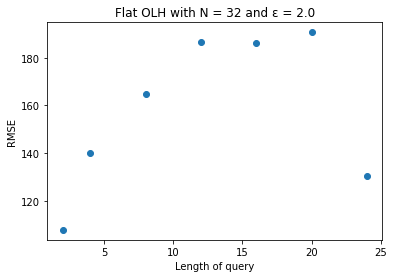

[20, 40, 50, 60, 70, 80, 90]
[1348.032499048328, 1922.9581161561525, 2077.3629516558954, 2165.9564635729016, 2278.628296009783, 2186.757515227652, 1836.604242655663]


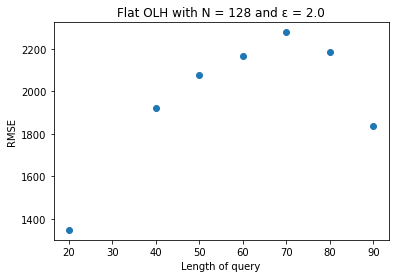

[40, 60, 80, 100, 140, 200, 220]
[3515.897025945121, 4324.643843862261, 4841.2980573848445, 5181.678735540088, 5517.39167992331, 4577.865945322885, 3431.1109280207816]


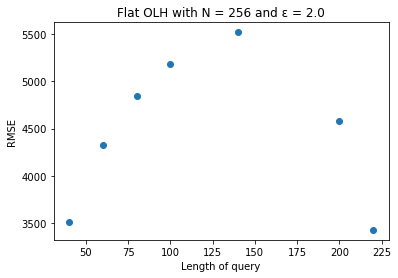

[100, 150, 200, 250, 300, 400, 450]
[6938.538645864586, 8243.570091665855, 8952.776762759424, 9371.301835501923, 9434.31039811788, 8739.496555958001, 8232.578312780704]


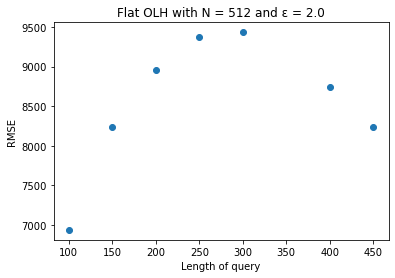

[200, 300, 400, 500, 600, 800, 900]
[24259.883157371736, 30493.089134689606, 33722.47680082472, 31368.251579459098, 27194.518895115405, 17277.24508192188, 19891.93979224746]


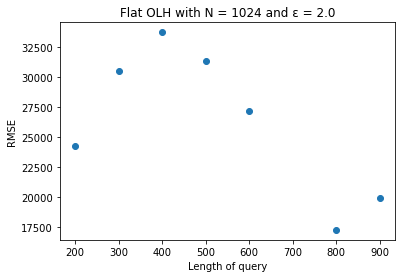

[600, 800, 900, 1000, 1500, 1700, 1800]
[90638.88979056336, 102121.75632716261, 86078.88267537972, 88569.52423832956, 57192.09660531855, 66270.12207141855, 73744.01641445082]


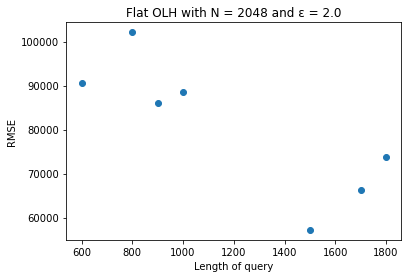

[2, 4, 8, 12, 16, 20, 24]
[163.48794179511773, 186.50639596352602, 256.32793943036694, 255.42387546711115, 263.3350664813785, 312.84593958497436, 294.80942958959974]


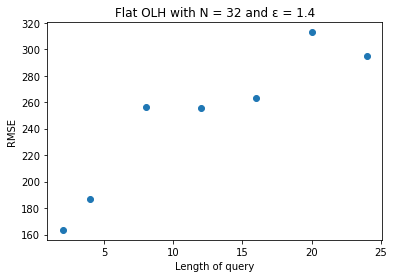

[20, 40, 50, 60, 70, 80, 90]
[1920.7424620129545, 2626.466627891601, 3015.6168511253722, 3343.564990476682, 3830.636510646653, 4005.6101942822334, 4098.58542018934]


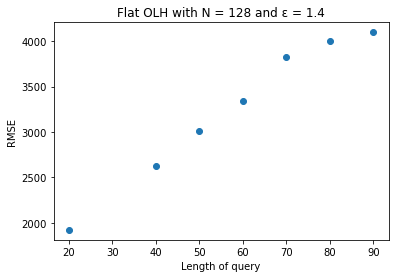

[40, 60, 80, 100, 140, 200, 220]
[5243.790940584936, 5876.528645770492, 5815.3429745397425, 4693.090254304899, 5179.3259154920415, 4051.109556320987, 4046.303547056512]


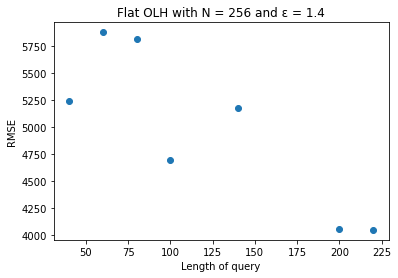

[100, 150, 200, 250, 300, 400, 450]
[16410.551197606328, 18418.012961369863, 18928.74268716084, 18986.410561380508, 17429.208688948867, 9253.89199993495, 8424.489533406799]


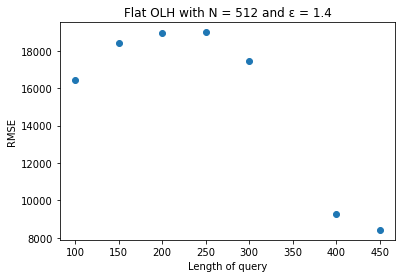

[200, 300, 400, 500, 600, 800, 900]
[45019.45125226988, 51467.08784704674, 51642.180115905365, 53041.42421533294, 56689.341885084774, 52046.21172007703, 51002.189786649855]


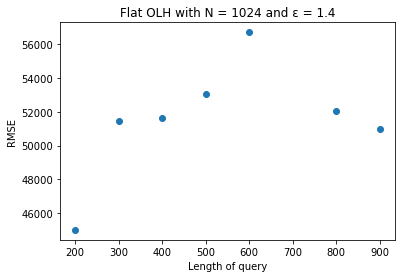

[600, 800, 900, 1000, 1500, 1700, 1800]
[104882.02628491011, 106459.01894967064, 113731.47629567895, 110161.78055014179, 112559.26349576616, 82559.23010688517, 64096.69697887291]


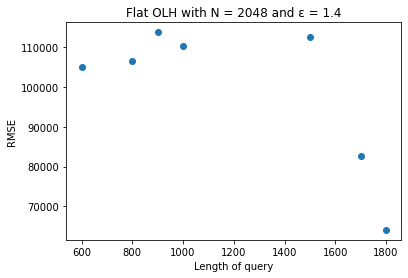

[2, 4, 8, 12, 16, 20, 24]
[206.5570613110765, 245.01246685396978, 289.8446888316588, 347.8470229045431, 335.6835329333107, 315.01401088955464, 200.04014200643704]


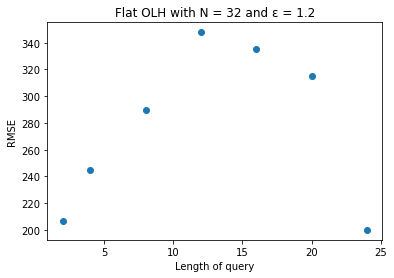

[20, 40, 50, 60, 70, 80, 90]
[3398.2579472448224, 4619.805214052269, 4500.562196790064, 3921.1655207223835, 3634.5306018374777, 3223.1537124269007, 2723.2651245877464]


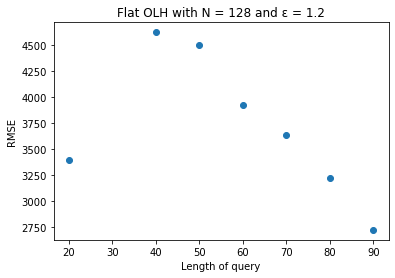

[40, 60, 80, 100, 140, 200, 220]
[8525.699499953687, 9689.341576443572, 10665.345260301245, 11639.5848254993, 13421.80705176353, 15944.71416516353, 12662.997896878285]


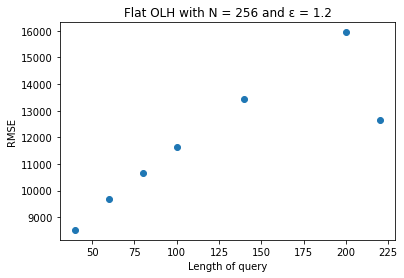

[100, 150, 200, 250, 300, 400, 450]
[16144.282375196035, 19434.759103459182, 21664.628182558652, 20527.828172983853, 20910.632651387117, 20234.27722009741, 17963.67665120734]


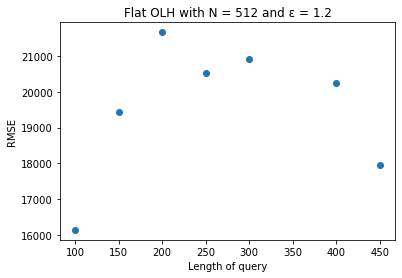

[200, 300, 400, 500, 600, 800, 900]
[65729.18482393102, 88927.75722644117, 93158.65678869258, 101049.91521386192, 101576.66308605215, 63322.07454140635, 50461.637430146606]


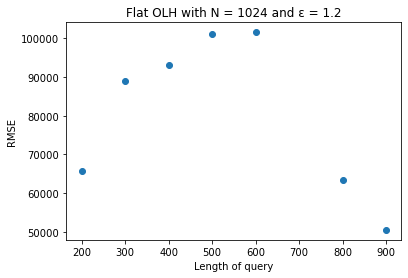

[600, 800, 900, 1000, 1500, 1700, 1800]
[279172.05465373537, 326740.0550546374, 138973.2634940444, 325686.1554916658, 200732.71152141097, 156880.50656641313, 94887.61393383634]


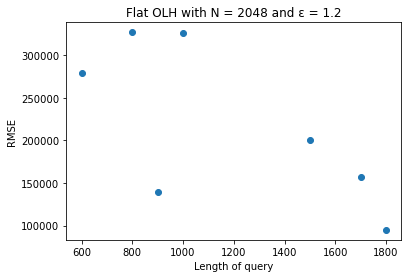

[2, 4, 8, 12, 16, 20, 24]
[221.11091900850192, 317.434691045202, 368.7741732871653, 439.43966640374043, 401.927697667498, 249.57070646527737, 260.4980022437288]


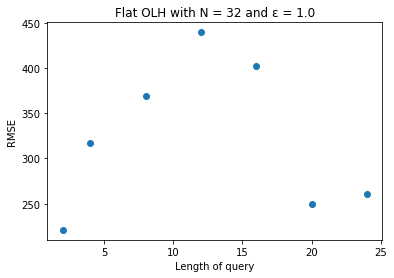

[20, 40, 50, 60, 70, 80, 90]
[2245.985816498783, 2114.115160281309, 2043.3822408302403, 2325.491591435644, 2348.9956572559013, 2549.103982616351, 2554.4052680579393]


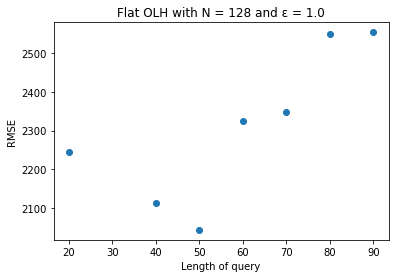

[40, 60, 80, 100, 140, 200, 220]
[7406.93603846872, 9389.01618954096, 11064.31668470454, 12132.689879820477, 12025.613688135665, 5723.780129493731, 3058.6627477878797]


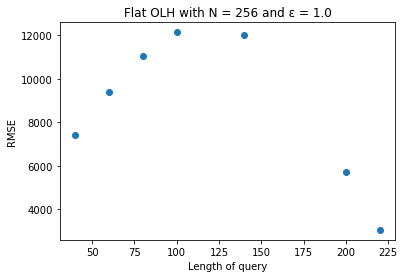

[100, 150, 200, 250, 300, 400, 450]
[19550.164194815898, 20977.205216991857, 24420.311582722803, 25440.59862998096, 20847.120904503994, 20159.16935088252, 15944.074410426601]


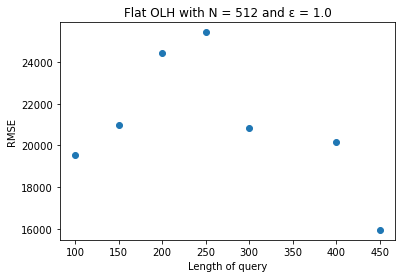

[200, 300, 400, 500, 600, 800, 900]
[65711.43120129926, 75123.71417991005, 93549.97956934062, 109032.19374009724, 122518.16731791668, 121630.43555288806, 79685.57189451031]


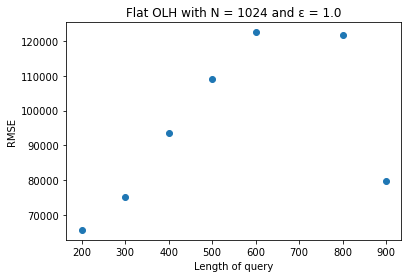

[600, 800, 900, 1000, 1500, 1700, 1800]
[163573.1084432799, 155535.2532946869, 339240.2499680259, 154556.36455227053, 153903.41002025592, 131397.53056603376, 126035.89329208626]


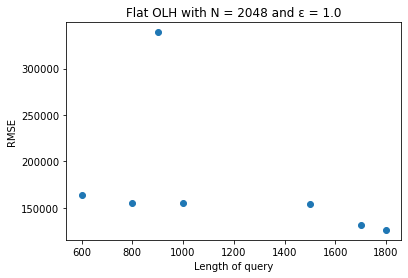

[2, 4, 8, 12, 16, 20, 24]
[232.2860281453497, 330.4865317290785, 426.64844423641193, 495.96260209228063, 385.06727586680444, 242.43317506101934, 298.98233578288097]


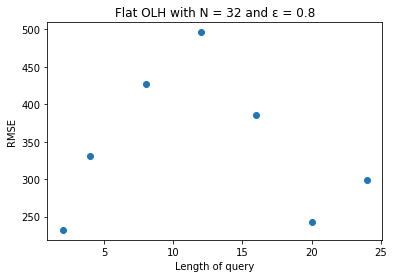

[20, 40, 50, 60, 70, 80, 90]
[3472.076900733858, 4099.666126635638, 4119.337841104933, 3968.280806101499, 2631.4397473618887, 2647.2933019822844, 2755.8837960861247]


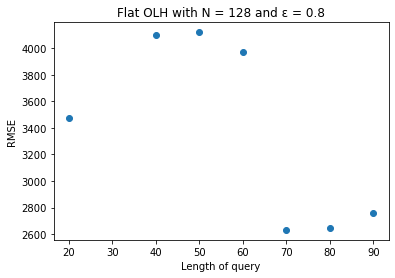

[40, 60, 80, 100, 140, 200, 220]
[7555.34065519128, 9028.725596410699, 10363.71399439714, 11395.308116367198, 10475.756680189821, 7628.3084435057135, 3894.2381388418667]


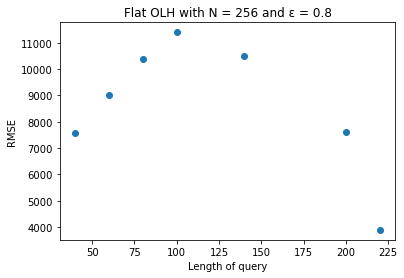

[100, 150, 200, 250, 300, 400, 450]
[26535.132694829066, 29283.796083145142, 28830.51822671184, 24860.50274098515, 20309.16205717748, 26246.02214971162, 24343.262916821634]


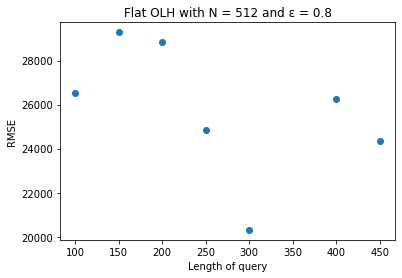

[200, 300, 400, 500, 600, 800, 900]
[80467.29352403266, 84251.43775525755, 85500.16043671584, 95160.25577087398, 104899.50153120956, 116642.3719552609, 81185.80842671372]


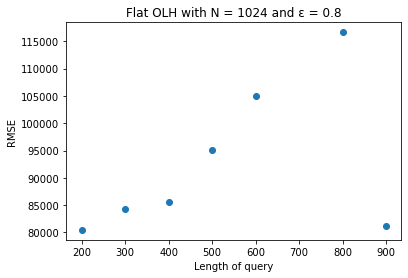

[600, 800, 900, 1000, 1500, 1700, 1800]
[416579.3018734145, 489790.6728215966, 329359.3110178083, 493619.9823416691, 375605.4580919905, 290920.7813275731, 223301.9911489492]


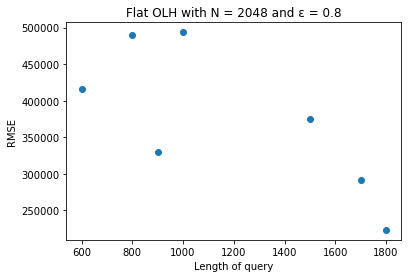

[2, 4, 8, 12, 16, 20, 24]
[334.7769486691297, 478.31186527649163, 660.6359325574656, 718.1327500149308, 725.3578036716216, 719.7198448087435, 606.8594889011245]


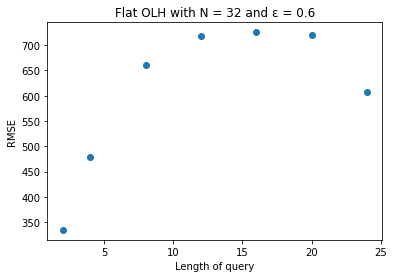

[20, 40, 50, 60, 70, 80, 90]
[3736.542338869801, 3555.024399742179, 3759.246366613631, 4423.792862057649, 4587.125141401603, 4147.522218734936, 3782.471565053314]


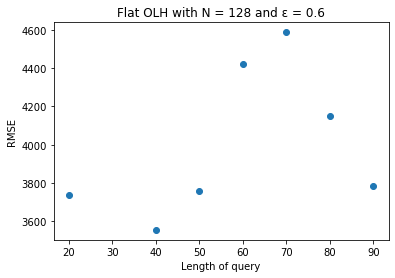

[40, 60, 80, 100, 140, 200, 220]
[11286.111101164275, 11584.986211832804, 13708.6027560288, 15540.611335552721, 14487.344244938095, 13109.63578834257, 8921.015071391572]


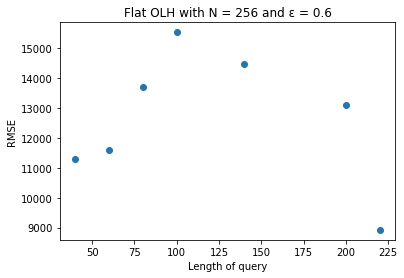

[100, 150, 200, 250, 300, 400, 450]
[32752.531426721103, 35826.716840024776, 34322.211634434156, 30511.36523309865, 33584.2851891528, 28664.38541490581, 15198.743923114345]


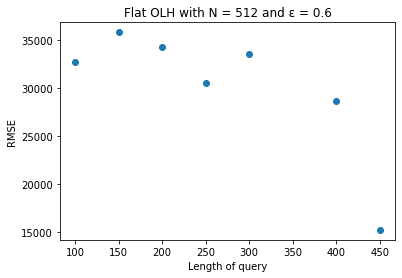

[200, 300, 400, 500, 600, 800, 900]
[110806.45090252202, 122382.65705437986, 134068.74289582256, 140370.04411561193, 138027.86806900785, 109385.18503067346, 59232.319655843996]


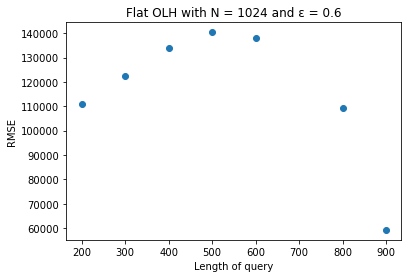

[600, 800, 900, 1000, 1500, 1700, 1800]
[304867.793450519, 341940.6074399183, 448224.1030843104, 340815.13499248965, 288629.36607458966, 235631.1857353048, 188892.01152577455]


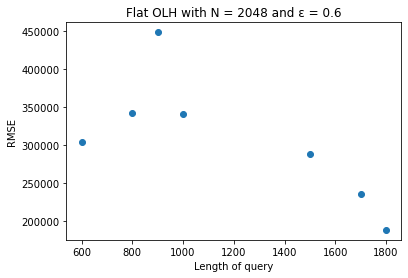

[2, 4, 8, 12, 16, 20, 24]
[399.0047514084856, 626.4137934615811, 764.7184477882207, 928.5346792758415, 904.3918409147955, 861.0664464860308, 590.583624676004]


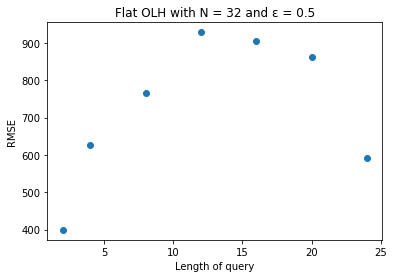

[20, 40, 50, 60, 70, 80, 90]
[4608.918133734307, 5571.322821583899, 5897.578531265939, 6544.725408098311, 6490.96113680632, 5863.2965222510165, 5597.779921435274]


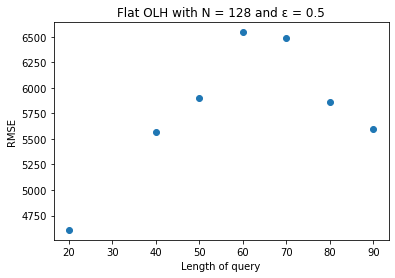

[40, 60, 80, 100, 140, 200, 220]
[12209.86641406088, 14019.97789435949, 16141.95770057452, 17417.663512048894, 14356.859802985437, 12245.852806248618, 12185.52966883839]


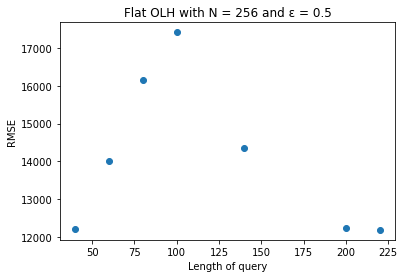

[100, 150, 200, 250, 300, 400, 450]
[37553.94296583912, 34727.78865147072, 31792.796895239942, 39257.63037679566, 45258.83830327387, 24783.8258767642, 13348.675940523182]


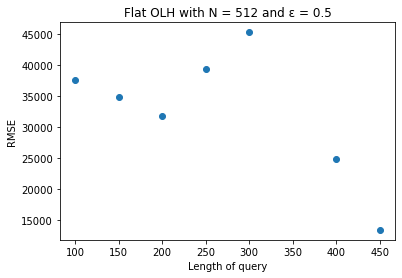

[200, 300, 400, 500, 600, 800, 900]
[80518.63662588439, 101739.23818190105, 107364.86570319814, 113513.53891911944, 120333.1826403014, 106719.94829412778, 74992.55044549252]


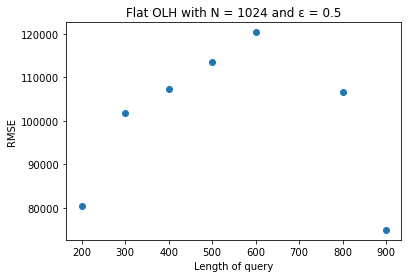

[600, 800, 900, 1000, 1500, 1700, 1800]
[394255.23247164837, 418318.14609827165, 369582.01035073947, 443486.10760669503, 373446.95378801716, 256355.72507349096, 177545.94338868177]


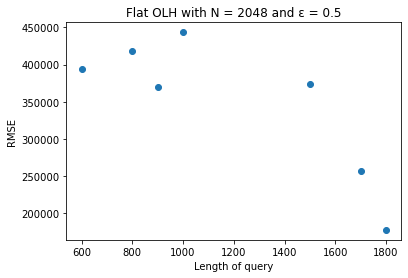

[2, 4, 8, 12, 16, 20, 24]
[447.4347227488613, 631.9166544646117, 648.2198207288525, 548.2225000601965, 621.3592240781663, 836.6233856621374, 710.3373651433734]


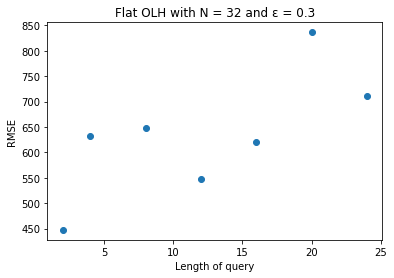

[20, 40, 50, 60, 70, 80, 90]
[5897.313999908183, 6232.120283989748, 7698.150559945249, 7748.304007874818, 7911.586405091165, 7695.420831948239, 7397.6837893750435]


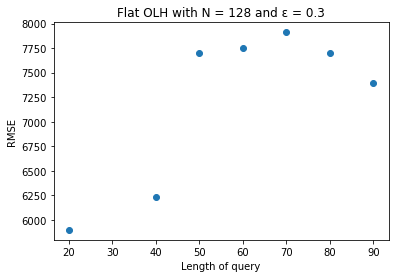

[40, 60, 80, 100, 140, 200, 220]
[11242.591328194034, 13649.405055878768, 14937.686190554548, 14930.07224415466, 16536.00408675149, 15745.507196103072, 12075.861552491]


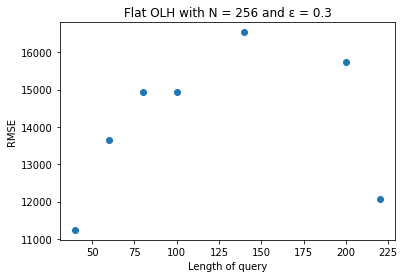

[100, 150, 200, 250, 300, 400, 450]
[34526.22752525342, 42532.58445095561, 46230.33410688828, 49893.81239475381, 53549.039844554936, 40681.48073138428, 26495.057435133844]


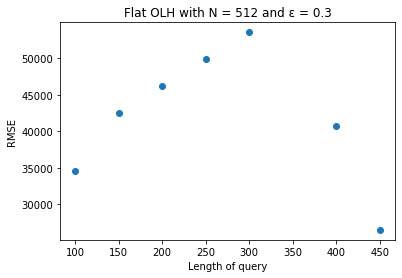

[200, 300, 400, 500, 600, 800, 900]
[98801.17541839047, 123639.51746545575, 136985.0471610179, 138832.81935971865, 133863.78135873083, 104807.84452377667, 106780.18943564165]


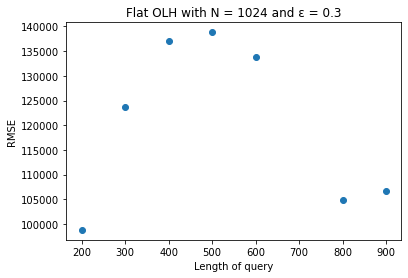

[600, 800, 900, 1000, 1500, 1700, 1800]
[556039.2817027617, 540133.9941455042, 532606.6812008636, 471120.48673623137, 519109.5452024057, 352553.02785958606, 240267.90969350666]


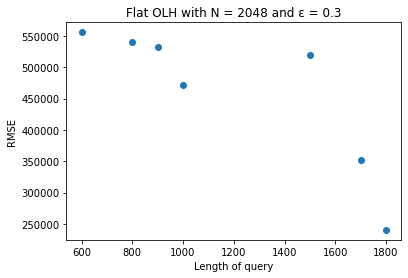

In [23]:
for e in epsilons:
    for N in n:
        xs = list(error_dict[e][N].keys())
        print(xs)
        ys = dict_plot_rmse_dict[e][N]
        print(ys)
        plot(xs, ys, N, e, 'e')
